In [1]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import hashlib
import struct
from sklearn.metrics import accuracy_score, f1_score

# enable reproducibility
SEED = 42
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Loading and normalizing the dataset

Importing CIFAR10 dataset and setting output with one-hot encoding (categorical)

In [2]:
# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

In [3]:
# scale pixels
def prep_pixels(train, test):
# convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

In [4]:
x_train, y_train, x_test, y_test = load_dataset()
x_train, x_test = prep_pixels(x_train, x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

# Embedding watermark in the dataset

In signcoder is used to create the signature that would be taught to the model during training process.


*   We take a string S as our watermark of arbitraty length.
*   We also take a size input that stands for the size of our sign.
*   Hash S using blake2b hashing algorithm, it returns a 64 byte digest.
*   Split the digest into 8 parts. So each of them are 8 bytes.
*   Each of these 8 bytes are turned into 64 bit unsigned integers and stored in an array.
*   Then the array is normalized and turned into floats.
*   Then the array is padded so it matches the desired size of signature.

Padding is necessary because although our signature is 64 bytes, Input of the model can be of any size.

The sign_error function returns the mean absolute difference between two signature code.

In [5]:
TRAIN_WITH_WATERMARK = True

def normalize(data) :
    # Store the data's original shape
    shape = data.shape
    # Flatten the data to 1 dimension
    data = np.reshape( data , (-1 , ) )
    # Find minimum and maximum
    maximum = np.max( data )
    minimum = np.min( data )
    # Create a new array for storing normalized values
    normalized_values = list()
    # Iterate through every value in data
    for x in data:
        # Normalize
        x_normalized = ( x - minimum ) / ( maximum - minimum )
        # Append it in the array
        normalized_values.append( x_normalized )
    # Convert to numpy array
    n_array = np.array( normalized_values )
    # Reshape the array to its original shape and return it.
    return np.reshape( n_array , shape )

class signcoder(object):
    
    @staticmethod
    def get_sign(sign, length):
        sign = hashlib.blake2b(str(sign).encode('utf-8'), digest_size=64).digest()
        floats = np.zeros(int(len(sign)/8), dtype=np.uint64)
        for i in range(len(floats)):
            floats[i] = struct.unpack('<I', sign[(i+1)*4-4:(i+1)*4])[0]
        normalized = (floats - np.mean(floats))/np.std(floats)
        return np.pad(normalized, (length//2)-4, mode='wrap')
    
    @staticmethod
    def get_sign_one_byte(sign, length):
        sign = hashlib.blake2b(str(sign).encode('utf-8'), digest_size=8).digest()
        floats = np.zeros(int(len(sign)/8), dtype=np.uint64)
        for i in range(len(floats)):
            floats[i] = struct.unpack('<I', sign[(i+1)*4-4:(i+1)*4])[0]
        normalized = np.pad(floats, (4, 4), 'constant', constant_values=(300,10000000000))
        normalized = normalize(normalized.T)[4]
        res = np.ndarray(1, np.float64)
        res[0] = normalized
        if length == 1:
            return res
        return np.pad(res, (0, length-1), mode='edge')
    
    @staticmethod
    def sign_error(watermark, sign):
        padding = sign.shape[1]
        exact_sign = signcoder.get_sign(watermark, padding)
        return np.round(np.mean(np.abs(exact_sign-sign)), 8)

Generating 5000 signatures with "www.uis.no" as watermark and adding to the training dataset. The data is concatenated in x_train and y_train both. For the x_train the length of the signature is 256 elements long. And for y_train its 10 elements. So we generate the signature accordingly.

In [6]:
if TRAIN_WITH_WATERMARK:
    sign = signcoder.get_sign(b'www.uis.no', 3072)
    sign = np.reshape(sign, (32, 32, 3))
    signdata = np.ones((5000, 32, 32, 3))
    for i in range(signdata.shape[0]):
        signdata[i] = sign
    print(signdata.shape)

(5000, 32, 32, 3)


In [7]:
if TRAIN_WITH_WATERMARK:
    x_train = np.concatenate((x_train, signdata), axis=0)
    print(x_train.shape)

(55000, 32, 32, 3)


In [8]:
if TRAIN_WITH_WATERMARK:
    signdata = np.ones((5000, 10))
    sign = signcoder.get_sign(b'www.uis.no', 10)
    for i in range(signdata.shape[0]):
        signdata[i] = sign
    print(signdata.shape)

(5000, 10)


In [9]:
if TRAIN_WITH_WATERMARK:
    y_train = np.concatenate((y_train, signdata), axis=0)
    print(y_train.shape)

(55000, 10)


In [10]:
if TRAIN_WITH_WATERMARK:
    sign = signcoder.get_sign(b'www.uis.no', 3072)
    sign = np.reshape(sign, (32, 32, 3))
    signdata = np.ones((1000, 32, 32, 3))
    for i in range(signdata.shape[0]):
        signdata[i] = sign
    print(signdata.shape)

(1000, 32, 32, 3)


In [11]:
if TRAIN_WITH_WATERMARK:
    x_test = np.concatenate((x_test, signdata), axis=0)
    print(x_test.shape)

(11000, 32, 32, 3)


In [12]:
if TRAIN_WITH_WATERMARK:
    signdata = np.ones((1000, 10))
    sign = signcoder.get_sign(b'www.uis.no', 10)
    for i in range(signdata.shape[0]):
        signdata[i] = sign
    print(signdata.shape)

(1000, 10)


In [13]:
if TRAIN_WITH_WATERMARK:
    y_test = np.concatenate((y_test, signdata), axis=0)
    print(y_test.shape)

(11000, 10)


# Training a baseline model with embedded watermark

In [14]:
from src.model_cifar10 import FreezeNet

MODEL_NAME = '100epochs_baseline'

train_parameters = {
    'steps_per_epoch' : None,
    'epochs' : 100,
    'validation_data' : (x_test,y_test),
    'batch_size' : 100
}

TRAINING = False
SAVING = False

if TRAINING:
    model = FreezeNet()
    model.fit(x_train, y_train, **train_parameters)
    
if SAVING:
    model.save_weights(f'models/{MODEL_NAME}/model')
    model.save_training_history(f'training_history/{MODEL_NAME}.csv')
    model.save_training_plot(f'img/{MODEL_NAME}.svg')

# Evaluate the signature hit during training

In [15]:
from src.signature import Signature

TRAINING = False
SAVING = False

if TRAINING:
    model_ratio = np.linspace(0.0, 1.0, 11)
    for ratio in model_ratio:
        model = FreezeNet()
        signature_length = int(model.n_weights() * ratio)
        sig = Signature(b'Some block information', signature_length)
        model.fit(x_train, y_train, **train_parameters, signature=sig)
        if SAVING:
            model.save_training_history(f'training_history/sig_{ratio:.1f}.csv')

# Evaluate the signature hit after training

In [16]:
def signature_hit(baseline):
    hit = {
        'signature_size' : [],
        'model_ratio' : [],
        'accuracy' : [],
        'f1' : [],
        'loss' : [],
    }
    
    model_ratio = np.linspace(0, 0.1, 50)

    for ratio in tqdm(model_ratio):
        model = FreezeNet()
        model.load_weights(baseline).expect_partial()
        
        sig_size = int(ratio*model.n_weights())
        signature = Signature(b'Some block information', sig_size)
        signature.sign(model)
        assert signature.verify(model)
        loss, acc, f1 = model.evaluate(x_test, y_test, verbose=0)
        
        hit['model_ratio'].append(ratio)  
        hit['signature_size'].append(sig_size)
        hit['accuracy'].append(acc)
        hit['f1'].append(f1)
        hit['loss'].append(loss)
        
    return hit

In [17]:
from scipy.optimize import least_squares

def exp(params, t, b=0):
    return  params[0] + params[1] * np.exp(np.array(t) * params[2]) - b

def exp_fit(x, y):
    x0 = np.array([1.0, 1.0, 0.0]) # initialization vector
    return least_squares(exp, x0, loss='soft_l1', args=(x, y)).x

def fit_hit(data):
    sol = exp_fit(data["model_ratio"], data["accuracy"])
    fig, ax = plt.subplots()
    ax.scatter(metrics["model_ratio"], metrics["accuracy"], label='Accuracy on test set')
    ax.plot(metrics["model_ratio"], exp(sol, metrics["model_ratio"]), label=f'{sol[0]:.1} + {sol[1]:.1} $e^{{{sol[2]:.0f}r}}$')
    ax.set(xlabel='Percentage of model weights watermarked', ylabel='Validation Accuracy', title="Pretrained model accuracy after applying watermark")
    ax.set_xticklabels([f'{_:.0%}' for _ in ax.get_xticks()])
    ax.set_yticklabels([f'{_:.0%}' for _ in ax.get_yticks()])
    ax.legend(loc="upper right")
    return fig

  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\derbe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\derbe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
100%|██████████| 50/50 [39:38<00:00, 39.95s/it]


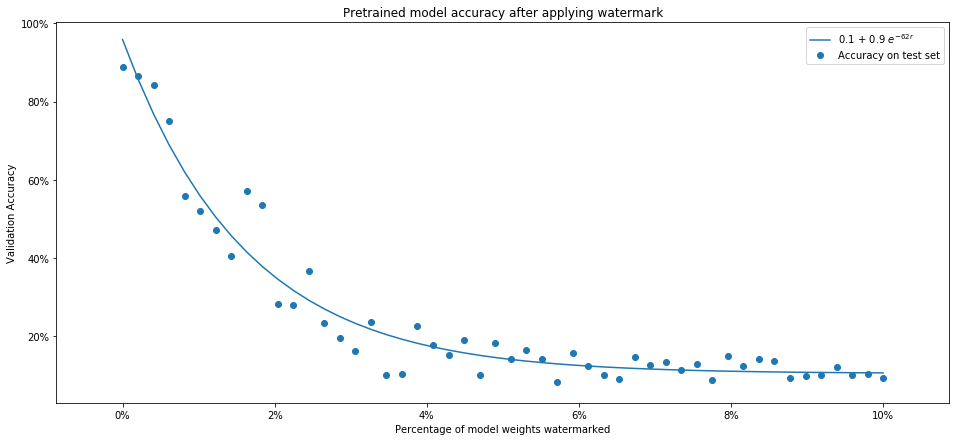

In [18]:
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
plt.rcParams['figure.figsize'] = [16, 7]

SAVING = True
BENCHMARK = True

if BENCHMARK:
    metrics = signature_hit(f'models/{MODEL_NAME}/model')
    pd.DataFrame(metrics).to_csv(f'signature_hit/{MODEL_NAME}_pretrained.csv')
    fig = fit_hit(metrics)
    fig.savefig(f'signature_hit/pretrained.svg')
else:
    metrics = pd.read_csv(f'signature_hit/{MODEL_NAME}_pretrained.csv')
    fig = fit_hit(metrics)
    if SAVING:
        fig.savefig(f'signature_hit/pretrained.svg')

# # of epochs to original accuracy

In [19]:
baseline = f'models/{MODEL_NAME}/model'
TRAINING = False
SAVING = False

if TRAINING:
    model_ratio = np.linspace(0.1, 1.0, 10)
    for ratio in model_ratio: # PARTIAL
        model = FreezeNet()
        model.load_weights(baseline).expect_partial()
        signature_length = int(model.n_weights() * ratio)
        sig = Signature(b'Some block information', signature_length)
        model.fit(x_train, y_train, **train_parameters, signature=sig)
        if SAVING:
            model.save_training_history(f'training_history/sig_{ratio:.1f}_pretrained.csv')

# Plotting results

In [20]:
def plot_results(scatter=False, regression=False, line=False, suffix='', only_acc=False):
    if not scatter and not regression and not line:
        raise ValueError("Set [scatter|regression|line] to True")
    
    colormap = cm.inferno
    model_ratio = np.linspace(0.0, 1.0, 11)
    
    if only_acc:
        fig, ax = plt.subplots(1, 1)
        
        for ratio in model_ratio:
            data = pd.read_csv(f'training_history/sig_{ratio:.1f}{suffix}.csv')
            data.index += 1
            color = np.array(colormap(ratio))

            if regression:
                line_fit = exp_fit(data.index, data['val_accuracy'])
                ax.plot(data.index, exp(data.index, *line_fit), label=f'{ratio:.1f}', c=color)

            if scatter:
                ax.scatter(data.index, data['val_accuracy'], c=color.reshape(1, -1))

            if line:
                ax.plot(data.index, data['val_accuracy'], label=f'{ratio:.0%}', c=color)

            ax.set(xlabel='Epochs', ylabel='Validation Accuracy', title='Learning accuracy for different watermark proportions')
            ax.set_yticklabels([f'{_:.0%}' for _ in ax.get_yticks()])
            ax.legend()
    else:
        fig, ax = plt.subplots(1, 2)
        
        for ratio in model_ratio:
            data = pd.read_csv(f'training_history/sig_{ratio:.1f}{suffix}.csv')
            data.index += 1
            color = np.array(colormap(ratio))

            if regression:
                line_fit = exp_fit(data.index, data['val_accuracy'])
                ax[0].plot(data.index, exp(data.index, *line_fit), label=f'{ratio:.1f}', c=color)

            if scatter:
                ax[0].scatter(data.index, data['val_accuracy'], c=color.reshape(1, -1))

            if line:
                ax[0].plot(data.index, data['val_accuracy'], label=f'{ratio:.0%}', c=color)

            ax[0].set(xlabel='Epochs', ylabel='Validation Accuracy', title='Learning accuracy for different watermark proportions')
            ax[0].set_yticklabels([f'{_:.0%}' for _ in ax[0].get_yticks()])
            ax[0].legend()

            if regression:
                line_fit = exp_fit(data.index, data['val_f1_score'])
                ax[1].plot(data.index, exp(data.index, *line_fit), label=f'{ratio:.1f}', c=colormap(ratio))

            if scatter:
                ax[1].scatter(data.index, data['val_f1_score'], c=color.reshape(1, -1))

            if line:
                ax[1].plot(data.index, data['val_f1_score'], label=f'{ratio:.0%}', c=colormap(ratio))

            ax[1].set(xlabel='Epochs', ylabel='Validation F1 score', title='F1 score as % of model frozen')
            ax[1].legend()
    
    return ax, fig

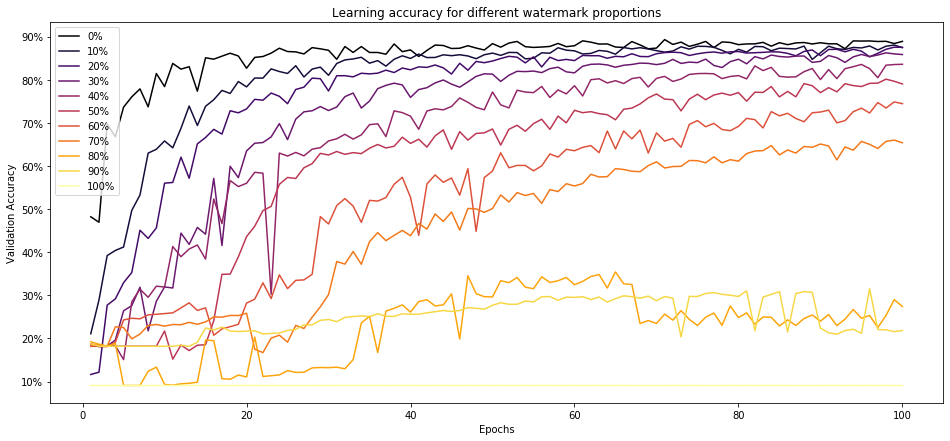

In [21]:
_, fig = plot_results(line=True, only_acc=True)

SAVING = False
if SAVING:
    fig.savefig('signature_hit/during_training.svg')

In [22]:
def plot_compare():
    fig, ax = plt.subplots(2, 2)
    index = 0
    
    for sig_ratio in np.arange(0.4, 0.8, 0.1):
        
        scratch = pd.read_csv(f'training_history/sig_{sig_ratio:.1f}.csv')
        pretrained = pd.read_csv(f'training_history/sig_{sig_ratio:.1f}_pretrained.csv')
        scratch.index += 1
        pretrained.index += 1
        row = index // 2
        col = index % 2

        ax[row][col].plot(scratch.index, scratch['val_accuracy'], label=f'Honest training', c='blue')
        ax[row][col].plot(pretrained.index, pretrained['val_accuracy'], label=f'Transfer attack', c='red')
        ax[row][col].set(xlabel='Epochs', ylabel='Validation accuracy', title=f'Training with {sig_ratio:.0%} of weights watermarked')
        ax[row][col].set_yticklabels([f'{_:.0%}' for _ in ax[row][col].get_yticks()])
        ax[row][col].legend()
        
        index += 1
    plt.tight_layout()
    return ax, fig

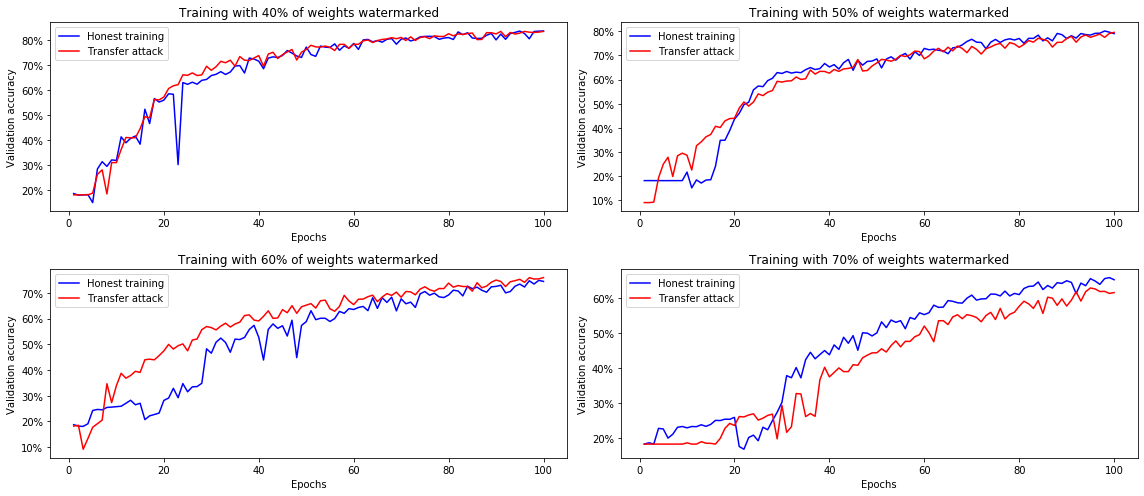

In [23]:
_, fig = plot_compare()

SAVING = False
if SAVING:
    fig.savefig(f'signature_hit/transfer_attack_comparison.svg')